In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([60000, 28, 28])
torch.Size([28, 60000, 28])
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


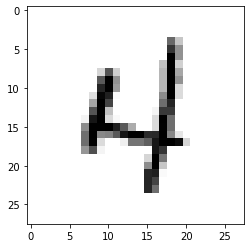

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print(train.data.shape)
print(train_data.shape)

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

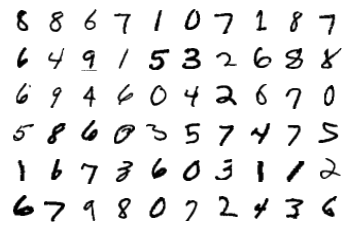

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # conv0_0
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
        ) # output_size = 26

        # Convolution 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # conv1_0  # output_size = 24
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # conv1_1  # output_size = 22
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        # Transition 1
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2), # trans1_pool0 # output_size = 11
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), # trans1_conv0  # output_size = 11
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
        )

        # Convolution 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # conv2_0 # output_size = 9
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # conv2_1 # output_size = 7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        # Output
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), # conv3_0 # output_size = 7
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False), # conv3_1 # output_size = 7x7x10 | 7x7x10x10 | 1x1x10
        )

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Receptive Field Calculations for all layers.

n_in | RF_in | k | p | s | J_in | J_out | RF_out | n_out | layer
-----|-------|---|---|---|------|-------|--------|-------|---------
28   |   1   | 3 | 0 | 1 | 1    |   1   |   3    |  26   | conv0_0
26   |   3   | 3 | 0 | 1 | 1    |   1   |   5    |  24   | conv1_0
24   |   5   | 3 | 0 | 1 | 1    |   1   |   7    |  22   | conv1_1
22   |   7   | 2 | 0 | 2 | 1    |   2   |   8    |  11   | trans1_pool0
11   |   8   | 1 | 0 | 1 | 2    |   2   |   8    |  11   | trans1_conv0
11   |   8   | 3 | 0 | 1 | 2    |   2   |   12   |  9    | conv2_0
9    |   12  | 3 | 0 | 1 | 2    |   2   |   16   |  7    | conv2_1
7    |   16  | 1 | 0 | 1 | 2    |   2   |   16   |  7    | conv3_0
7    |   16  | 7 | 0 | 1 | 2    |   2   |   28   |  1    | conv3_1

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", "trainable"],
    row_settings=["var_names"]
)

cuda
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net (Net)                                --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Sequential (conv0)                     --                        [20, 1, 28, 28]           [20, 10, 26, 26]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 1, 28, 28]           [20, 10, 26, 26]          90                        1,216,800                 True
│    └─ReLU (1)                          --                        [20, 10, 26, 26]          [20, 10, 26, 26]          --                        --                        --
│    └─BatchNorm2d (2)                   --                        [20, 10, 26, 26]          [20, 10, 26, 26]   

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  # epoch accuracy = accuracy for the whole batch
  epoch_train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07574198395013809 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:06<00:00, 73.25it/s]


Test set: Average loss: 0.0601, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.07065469771623611 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:06<00:00, 77.15it/s]


Test set: Average loss: 0.0422, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.044940173625946045 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:05<00:00, 79.83it/s]


Test set: Average loss: 0.0384, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.11652963608503342 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:06<00:00, 77.46it/s]


Test set: Average loss: 0.0328, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.06351755559444427 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:06<00:00, 78.00it/s]


Test set: Average loss: 0.0343, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.010851484723389149 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:06<00:00, 76.77it/s]


Test set: Average loss: 0.0287, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.02874128706753254 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:06<00:00, 76.35it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.109456866979599 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:06<00:00, 76.66it/s]


Test set: Average loss: 0.0297, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.048531681299209595 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:05<00:00, 78.30it/s]


Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.014293459244072437 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:05<00:00, 79.30it/s]


Test set: Average loss: 0.0265, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.014011438004672527 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:05<00:00, 79.06it/s]


Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.013317952863872051 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:06<00:00, 77.07it/s]


Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.006616645958274603 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:05<00:00, 78.56it/s]


Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.006901521235704422 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:06<00:00, 77.37it/s]


Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.001486718188971281 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:05<00:00, 79.20it/s]


Test set: Average loss: 0.0240, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

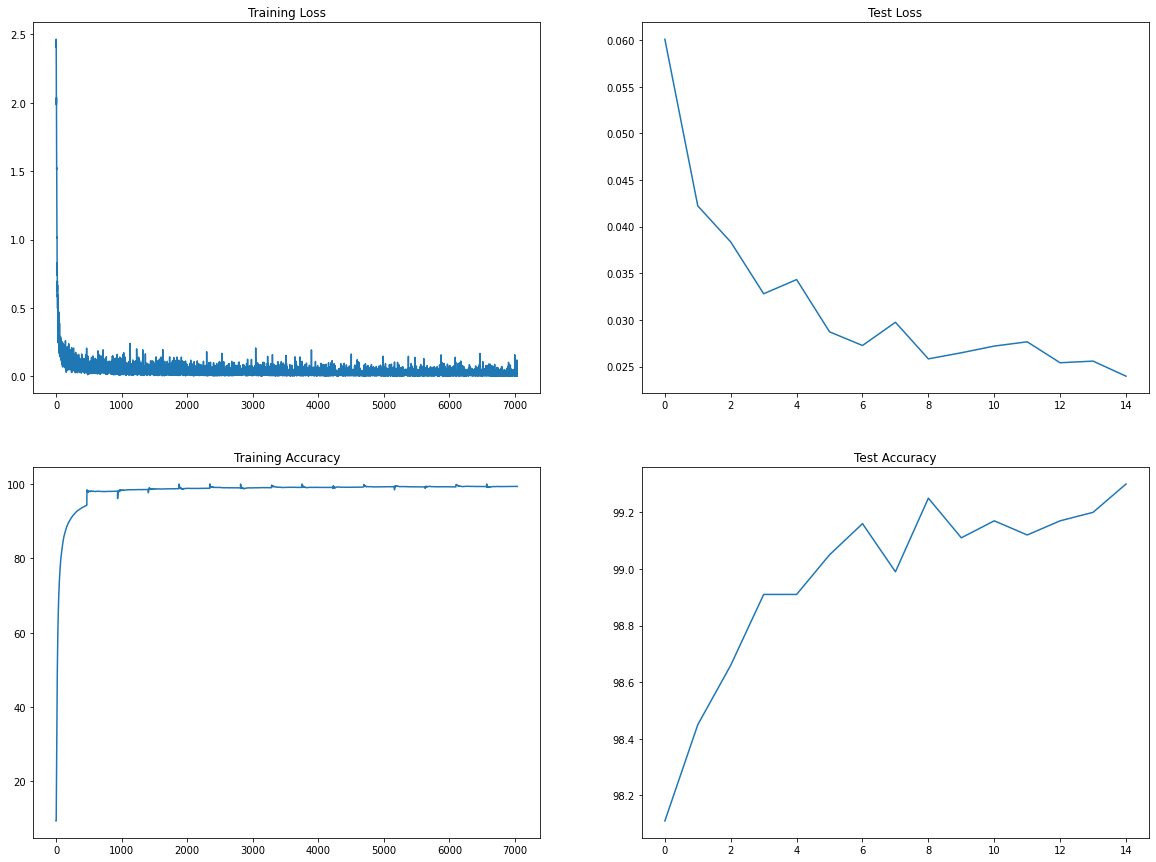

In [12]:
fig, axs = plt.subplots(2,2,figsize=(20,15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
print("Minimum training loss = {:.9f}%".format(min(train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(test_losses)))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc)))
print("Best testing accuracy = {:.2f}%".format(max(test_acc)))

Minimum training loss = 0.000592759%
Minimum testing loss = 0.023961324%
Best training accuracy = 99.35%
Best testing accuracy = 99.30%



# Target:

1.  Add regularization (dropout) to make learning harder in hopes of increasing testing accuracy

# Results:

*   Parameters = 10,154
*   Best training accuracy = 99.35%
*   Best testing accuracy = 99.30%

# Analysis:

*   Model has exceeded its target size after adding batch normalization in previous iteration (batch normalization). Parameters were unaffected (as expected) after adding dropout
*   Model is not over-fitting, but I could not achieve the target testing accuracy